In [ ]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [3]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [4]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [5]:
suffix = "_TrueVertexForSignal"

In [6]:
cut_config = "./cut_configs/preselections_BDTv2.py"

In [7]:
sig_sample_json_dir = '../'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_mA_3m1_2018_aEM_ctau-10." in samp ]
print(signal_list)

bkg_sample_json_dir = '../../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_mA_3m1_2018_aEM_ctau-10']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [8]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_mA_3m1_2018_aEM_ctau-10


Output()

Output()

Completed in 0.80 min



In [9]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.85 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.53 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 3.32 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 5.08 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.32 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.43 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.46 min



## BDT

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
h5_dir = "./h5/"
sig_suffix = "ctau-10_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

ctau = '10_'
sig_files = [f for f in os.listdir(h5_dir) if (sig_suffix in f and 'sig' in f) and (str(ctau) in f)]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# vtx variables
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif']

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

In [ ]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

ctau = 10.
for delta in [0.1, 0.2]:
    for m1 in [5.,10.,20.,30.,40.,50.]:
        idx = ((sig_point['m1'] == m1) & (sig_point['delta'] == delta))&(sig_point['ctau'] == ctau)
        point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
        sig_subprocess[point] = idx
        print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses with non-zero count: {nSamp}')

## Reweight Backgrounds

### Background raw counts

In [ ]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

### Cutflow counts (xsec weighted)

In [ ]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [ ]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        #print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()]

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [ ]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

In [ ]:
nBkg

In [ ]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

#print(len(bkg_sf))

In [ ]:
set(bkg_xsec_norm)

In [ ]:
len(bkg_sf)

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [ ]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

In [ ]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

In [ ]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

In [ ]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

In [ ]:
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    sig_sf[samp_idx] = sf

print(sig_sf)

In [ ]:
type(sig_sf)

### Train

In [ ]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [ ]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [ ]:
test_ctau[np.where(y_test == 1)] # signal

In [ ]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

In [31]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [32]:
# make predictions
preds = bst.predict(test)

In [33]:
os.system('mkdir -p plots')

0

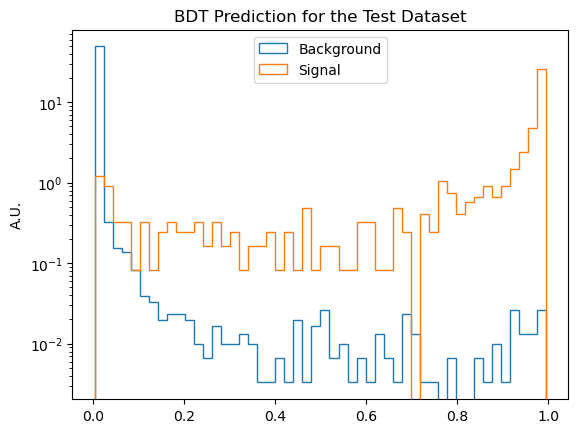

In [34]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.savefig('plots/BDTv2_ctau-10_score.png')
plt.yscale('log')

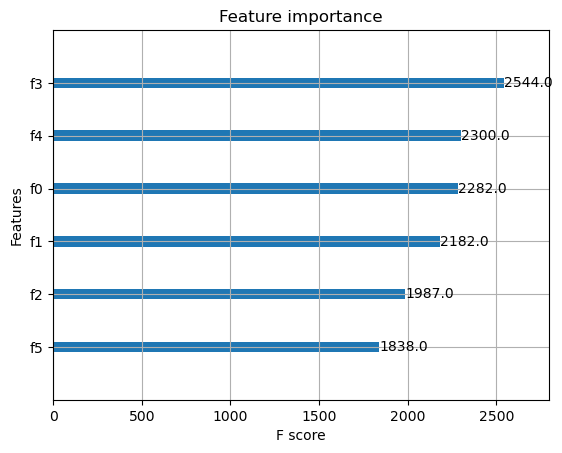

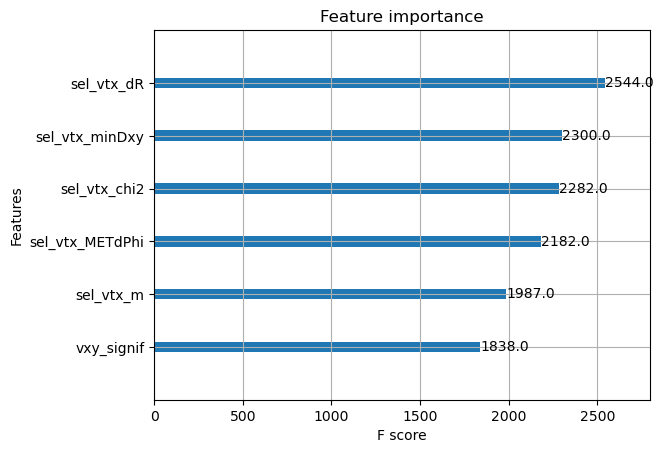

In [35]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
plt.savefig('plots/BDTv2_ctau-10_importance_bst.png', bbox_inches = "tight")

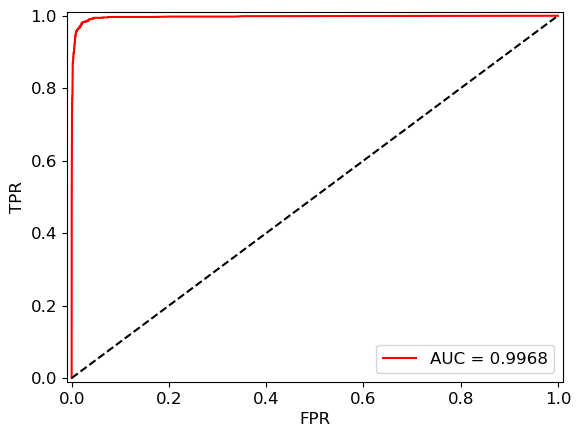

In [36]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
plt.savefig('plots/BDTv2_ctau-10_roc_curve.png')

### Save and load

In [37]:
bst.save_model('models/BDTv2_ctau-10_5to50.json')

In [ ]:
trained_model = xgb.XGBRegressor()
trained_model.load_model("models/BDTv2_ctau-10_5to50.json")

In [ ]:
prediction = trained_model.predict(test)

In [ ]:
bins = 50

h,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset (model loaded)')

plt.ylabel('A.U.')
plt.yscale('log')

In [ ]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

In [ ]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### WP

In [ ]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [ ]:
tpr_WP = {'tight': 0.7, 'medium': 0.85, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [ ]:
epsilon = 0.005

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')